In [ ]:
from __future__ import annotations
import torch
import pytomography

from pytomography.metadata.CT import CTConeBeamFlatPanelProjMeta
from pytomography.metadata import ObjectMeta
from pytomography.likelihoods import PoissonLogLikelihood
import numpy as np
from pytomography.projectors.CT import CTConeBeamFlatPanelSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.algorithms import SART
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn.functional import interpolate


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


Frst lets specify the save path of the data:

In [ ]:
paths = paths = [f'/disk1/SophiaBeads_256_averaged/SophiaBeads_256_averaged_0{i:03}.tif' for i in range(1, 256)]

In this case, we'll manually load the data (hopefully I'll write a data loader soon). This involves opening the projection data, adjusting units from $Ie^{-\int \mu dx}$ to $\int \mu dx$, and resizing the projections from 2000x2000 to a smaller size to make reconstruction feasible on most computers:

In [ ]:
g = []
white_level = 6e4
reduction = 4
size = 2000 // reduction # original projection size reduced to save memory
for path in paths:
    im = np.array(Image.open(path))
    im = -np.log(im / white_level) # convert to sum of attenuation coefficient
    im = torch.tensor(im.astype(np.float32))
    im = interpolate(torch.tensor(im).unsqueeze(0).unsqueeze(0), size=(size,size)).squeeze()
    g.append(im.T)
g = torch.stack(g)
g = g.to(pytomography.device)

/tmp/ipykernel_21090/1795341116.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  im = interpolate(torch.tensor(im).unsqueeze(0).unsqueeze(0), size=(500,500)).squeeze()


KeyboardInterrupt: 

In [ ]:
SCALE = 4
dr = 0.2 * SCALE
R_b = 80.6392412185669
R_d = 1007.003 - R_b

thetas = -torch.tensor(np.genfromtxt('/disk1/SophiaBeads_256_averaged/SophiaBeads_256_averaged.ang', skip_header=1)[:,1]) * np.pi / 180
zs = torch.zeros(len(thetas))

proj_meta = CTConeBeamFlatPanelProjMeta(
    thetas,
    zs,
    R_d,
    R_b,
    shape = (size, size),
    dr = (dr,dr),
    COR=0.22
)
dx = 0.06
Nx = 500
Nz = 200
object_meta = ObjectMeta(dr=(dx,dx,dx), shape=(Nx,Nx,Nz))

In [ ]:
#system_matrix = CTCBSystemMatrix(object_meta, proj_meta, N_splits=10, device='cpu')
system_matrix = CTConeBeamFlatPanelSystemMatrix(object_meta, proj_meta, N_splits=1)

In [ ]:
#recon_FDK = system_matrix.backward(g.cpu(), projection_type='FBP')
recon_FDK = system_matrix.backward(g, projection_type='FBP')

In [ ]:
fhat = system_matrix.backward(g)

Text(0.5, 1.0, 'PyTomography')

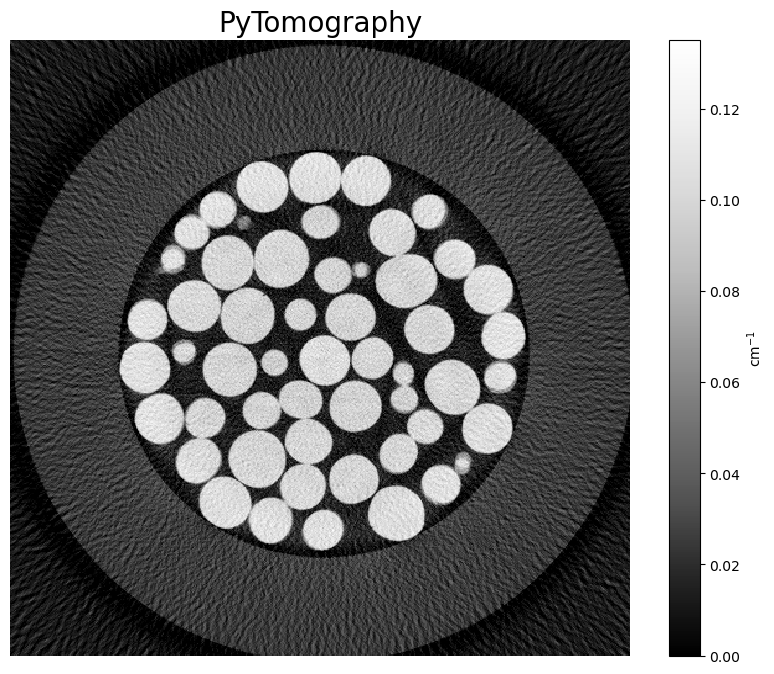

In [ ]:
z_idx = 99
plt.figure(figsize=(10,8))
plt.pcolormesh(recon_FDK[:,:,z_idx].cpu().T, cmap='Greys_r', vmin=0)
plt.axis('off')
plt.colorbar(label=r'$\text{cm}^{-1}$')
plt.title('PyTomography', fontsize=20)

Try OSEM

In [ ]:
g_positive = g.clone()
g_positive[g<0] = 0

In [ ]:
likelihood = PoissonLogLikelihood(system_matrix, g_positive)

In [ ]:
recon_algorithm = OSEM(likelihood)
recon_OSEM = recon_algorithm(n_iters = 12, n_subsets = 8)

Text(0.5, 1.0, 'PyTomography')

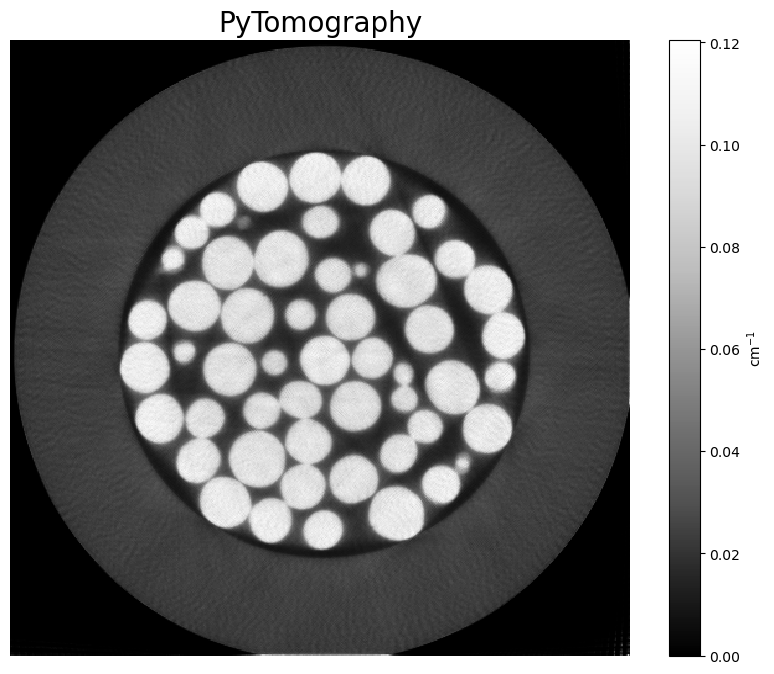

In [ ]:
z_idx = 99
plt.figure(figsize=(10,8))
plt.pcolormesh(recon_OSEM[:,:,z_idx].cpu().T, cmap='Greys_r', vmin=0)
plt.axis('off')
plt.colorbar(label=r'$\text{cm}^{-1}$')
plt.title('PyTomography', fontsize=20)